# <center> EKE </center> #



In [21]:
# Some parameters
VAR = 'Psi'  # Pick what plot
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Year = 'PSI.nc'
Qplot = 'Y'

In [22]:
# Load in Modules
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy.ma as ma
import sys
import cmocean
from matplotlib import gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from HB_Plot import nf, fmt
import SG
import useful as hb
import layers_calc
import APE_Calc as AC
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']

# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/VSQ.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

In [23]:
fname = x+'/3daynokpp/'
c = utils.ChannelSetup(output_dir=str(fname))

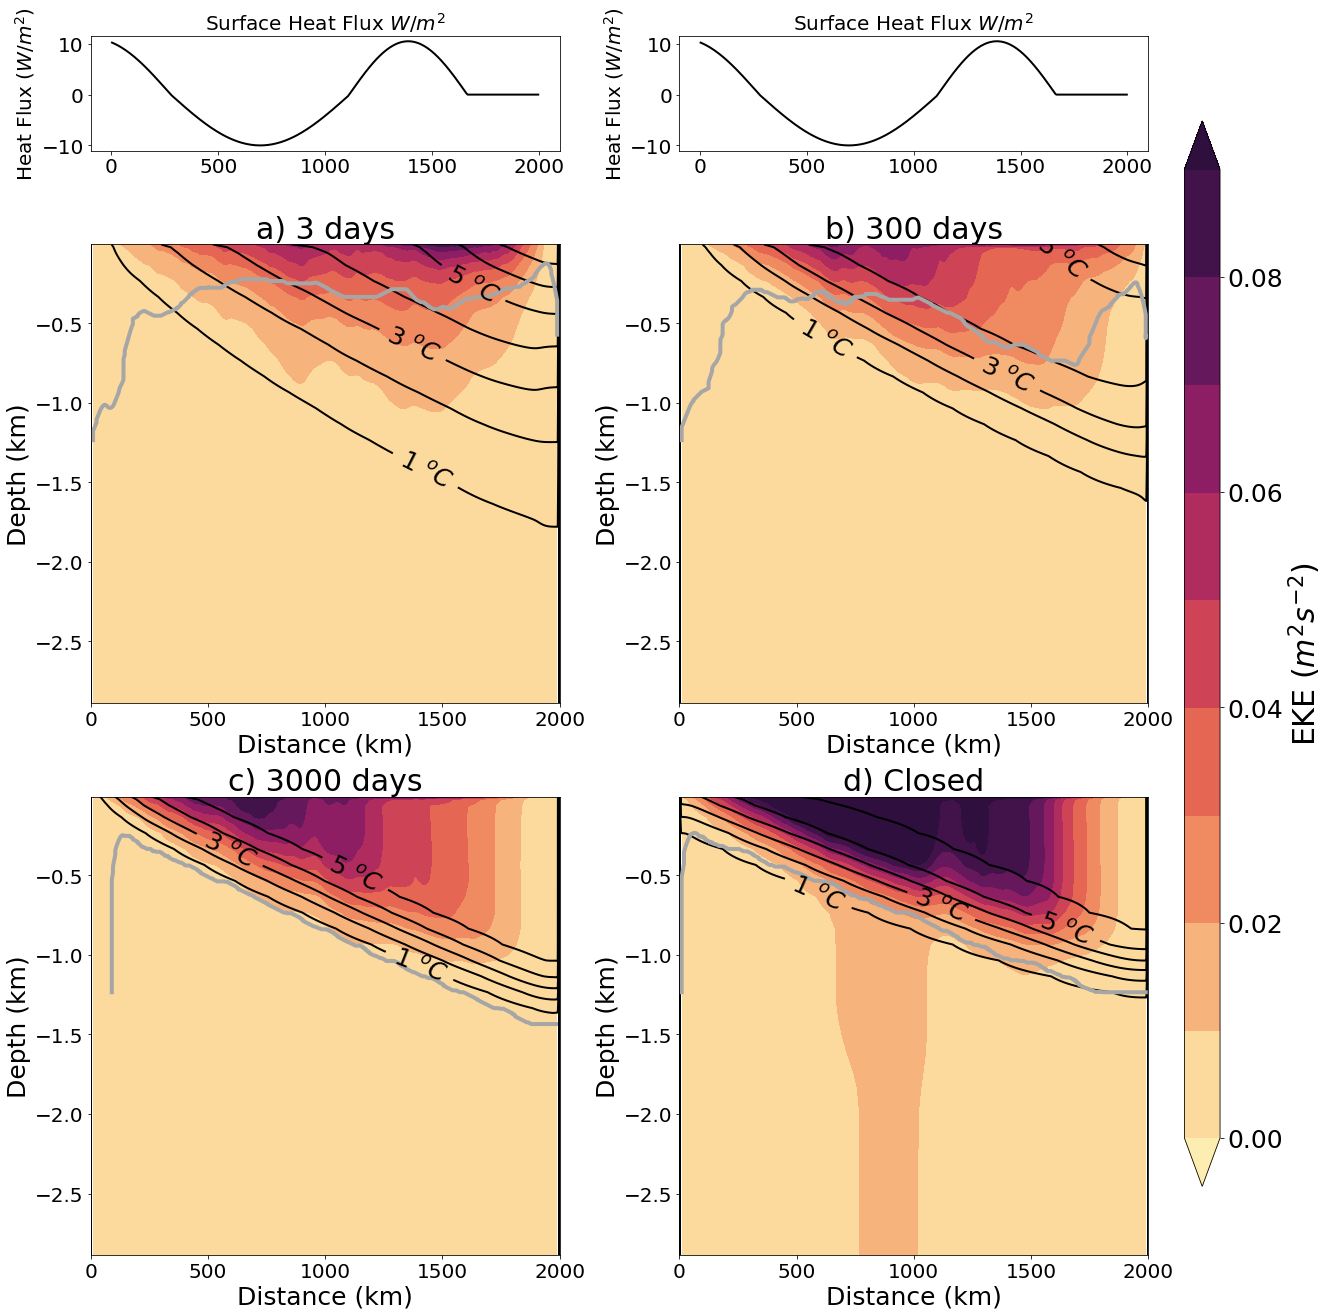

In [24]:
fig = plt.figure(figsize=(16.5, 18.5))
# Create Panels
EKEt = []
Psi_levs = np.arange(-0., .10, .010)
Psi_ticks = np.arange(-0., .10, .02)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
ax = plt.subplot(gs[0])
ax.plot(c.yc/1000, -Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
ax.plot(c.yc/1000, -Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    EKE = c.calc_EKE()


    ax = plt.subplot(gs[2+i])
    Q2_levs = (np.arange(-1, 8, 1))
    p = ax.contourf(c.yc/1000, c.zc/1000,
                    EKE, Psi_levs, cmap=cmocean.cm.matter , extend='both')
    Tavlat = c.get_zonal_avg('Tav.nc', 'THETA')
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*c.dzf)/-c.zc[-1])
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs,
                   colors='k', linewidths=2)
     # Plot mixed layer depth via layer probability
    g = layers_calc.LayersComputer(c)
    PI = c.mnc('PSI.nc', "LaPs1TH").mean(axis=2)
    th = c.mnc('PSI.nc', "LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI, th)
    # Remove some nonsense
    PIz[-5::, 50::] = np.nan
    # Plot very messy contour of lowest depth layer might not occur.
    # Check rough consistencey with MLD intitially then remove from code
    #mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:].mean(axis=1)
    #R = ax.plot(c.yc/1000, SG.savitzky_golay(-mld/1000, 21, 1), scalex=False,
    #           scaley=False, color='0.8', linestyle='-', linewidth=6)
    
    P = 0.999999999
    r = ax.contour(c.yg/1000, c.zc/1000, PIz, [P],
                   colors='0.75', linewidths=3)
    # Extract the contour data 
    dat0 = r.allsegs[0][0]
    if i>2:
        dat0= r.allsegs[0][1]
    # Plot nice thick smoothed line!
    s = ax.plot(dat0[15:-10,0],SG.savitzky_golay(dat0[15:-10,1],27,1),color='0.65', linewidth=4)
    # Remove the messy countour
    ax.collections.pop(-1)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' days', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_ylabel('Depth (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('EKE $(m^2s^{-2})$', fontsize=30, )
cbar.ax.tick_params(labelsize=25)


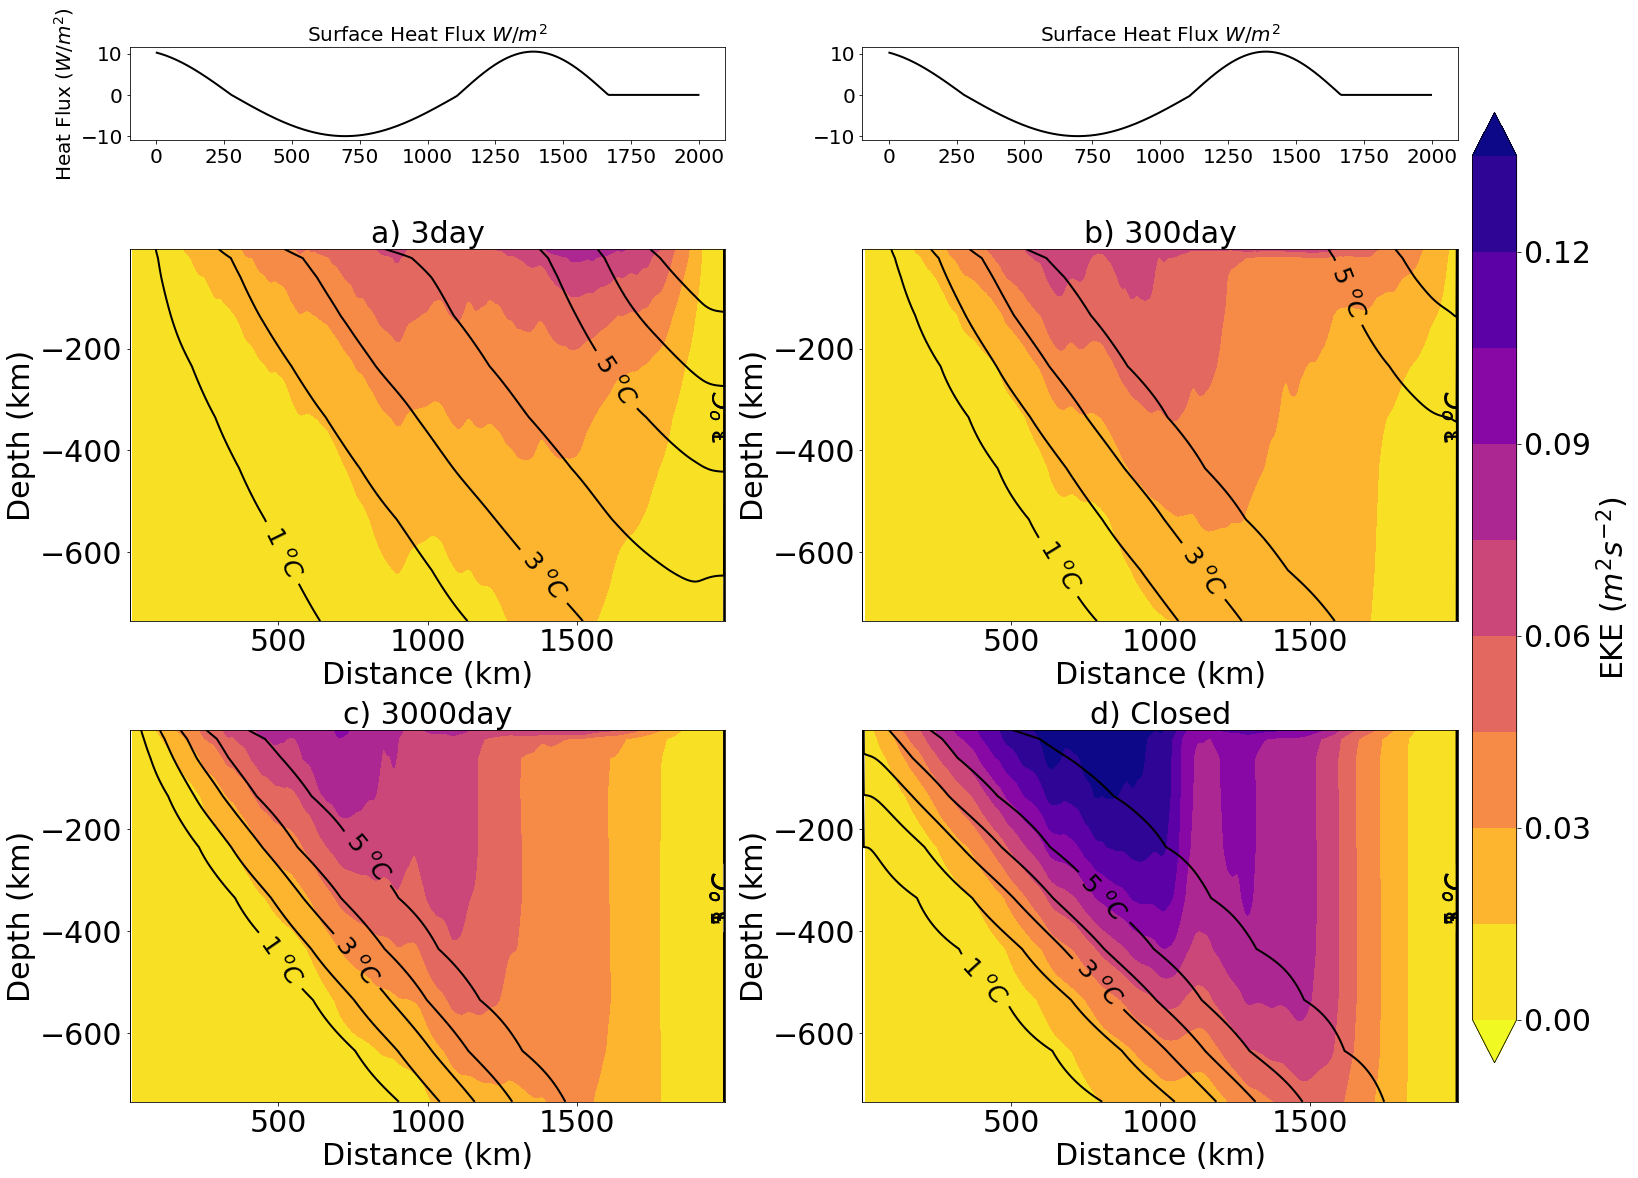

In [25]:
fig = plt.figure(figsize=(20.5, 16.5))
# Create Panels
Psi_levs = np.arange(-0., .15, .015)
Psi_ticks =np.arange(-0., .15, .03)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4, 4])
ax = plt.subplot(gs[3])
ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
if Full == 'N':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    EKE = c.calc_EKE()
    
    ax = plt.subplot(gs[2+i])
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(c.yc/1000, c.zc[0:10],
                EKE[0:10,:], Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*c.dzf)/-c.zc[-1])
    q = ax.contour(c.yc/1000, c.zc[0:10], Tavlat[0:10,:], Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel(r'EKE $(m^2s^{-2})$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

In [26]:
EKE = []
EKEt = []
EKEdl = []
DLV = []
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    CellVol =np.tile(c.dzf,(c.Ny,1)).T
    # PLOT PANNELS
    
    CellVol = 5000*5000*1000*np.tile(c.dzf,(c.Nx,c.Ny,1)).T/c.Nx
    EKE1 = c.calc_EKE_all()*CellVol
    EKE1 = np.sum(EKE1,axis=2)

    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    DDL = np.zeros(len(c.yc))
    EKE_DL = np.zeros(len(c.yc))
    psi = c.get_psi_iso()
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<0.9999999999)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[0]
        else:
            a = b[0]
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            DDL[jj] = (depths[a-1,jj]+depths[a,jj])/2
        else:
            DDL[jj] = depths[a,jj]
            if DDL[jj]>c.zc[1]:
                EKE_DL[jj] = EKE1[0,jj]
            else:
                EKE_DL[jj] = np.nansum(EKE1[0:np.where(np.round(c.zc)==
                                                    np.round(hb.find_nearest(c.zc,-DDL[jj])))[0][0],jj])
    EKEdl.append(np.nansum(EKE_DL))
    DLV.append(np.sum(DDL*5000))


(3.0, 200000)

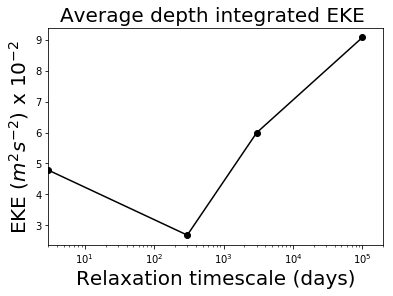

In [28]:
plt.plot([3,300,3000,10**5],np.array(EKEdl)*10**-12,'-ko')
plt.xscale("log")
plt.xlabel('Relaxation timescale (days)', fontsize=20)
plt.ylabel(r'EKE $(m^2 s^{-2})$ x $10^{-2}$', fontsize=20)
plt.title('Average depth integrated EKE ', fontsize=20)
#plt.ylim(0,.65)
plt.xlim(0,2*10**5)

In [29]:
plt.plot([3,300,3000,10**5],((EKEt-EKEt[0])/(np.sum(CellVol)))*10**6,'-ko')
plt.xscale("log")
plt.xlabel('Relaxation timescale (days)', fontsize=20)
plt.ylabel(r'EKE $(m^2 s^{-2})$ x $10^{-6}$', fontsize=20)
plt.title('Change in average EKE', fontsize=20)
plt.ylim(0,1.)
plt.xlim(0,2*10**5)

IndexError: list index out of range

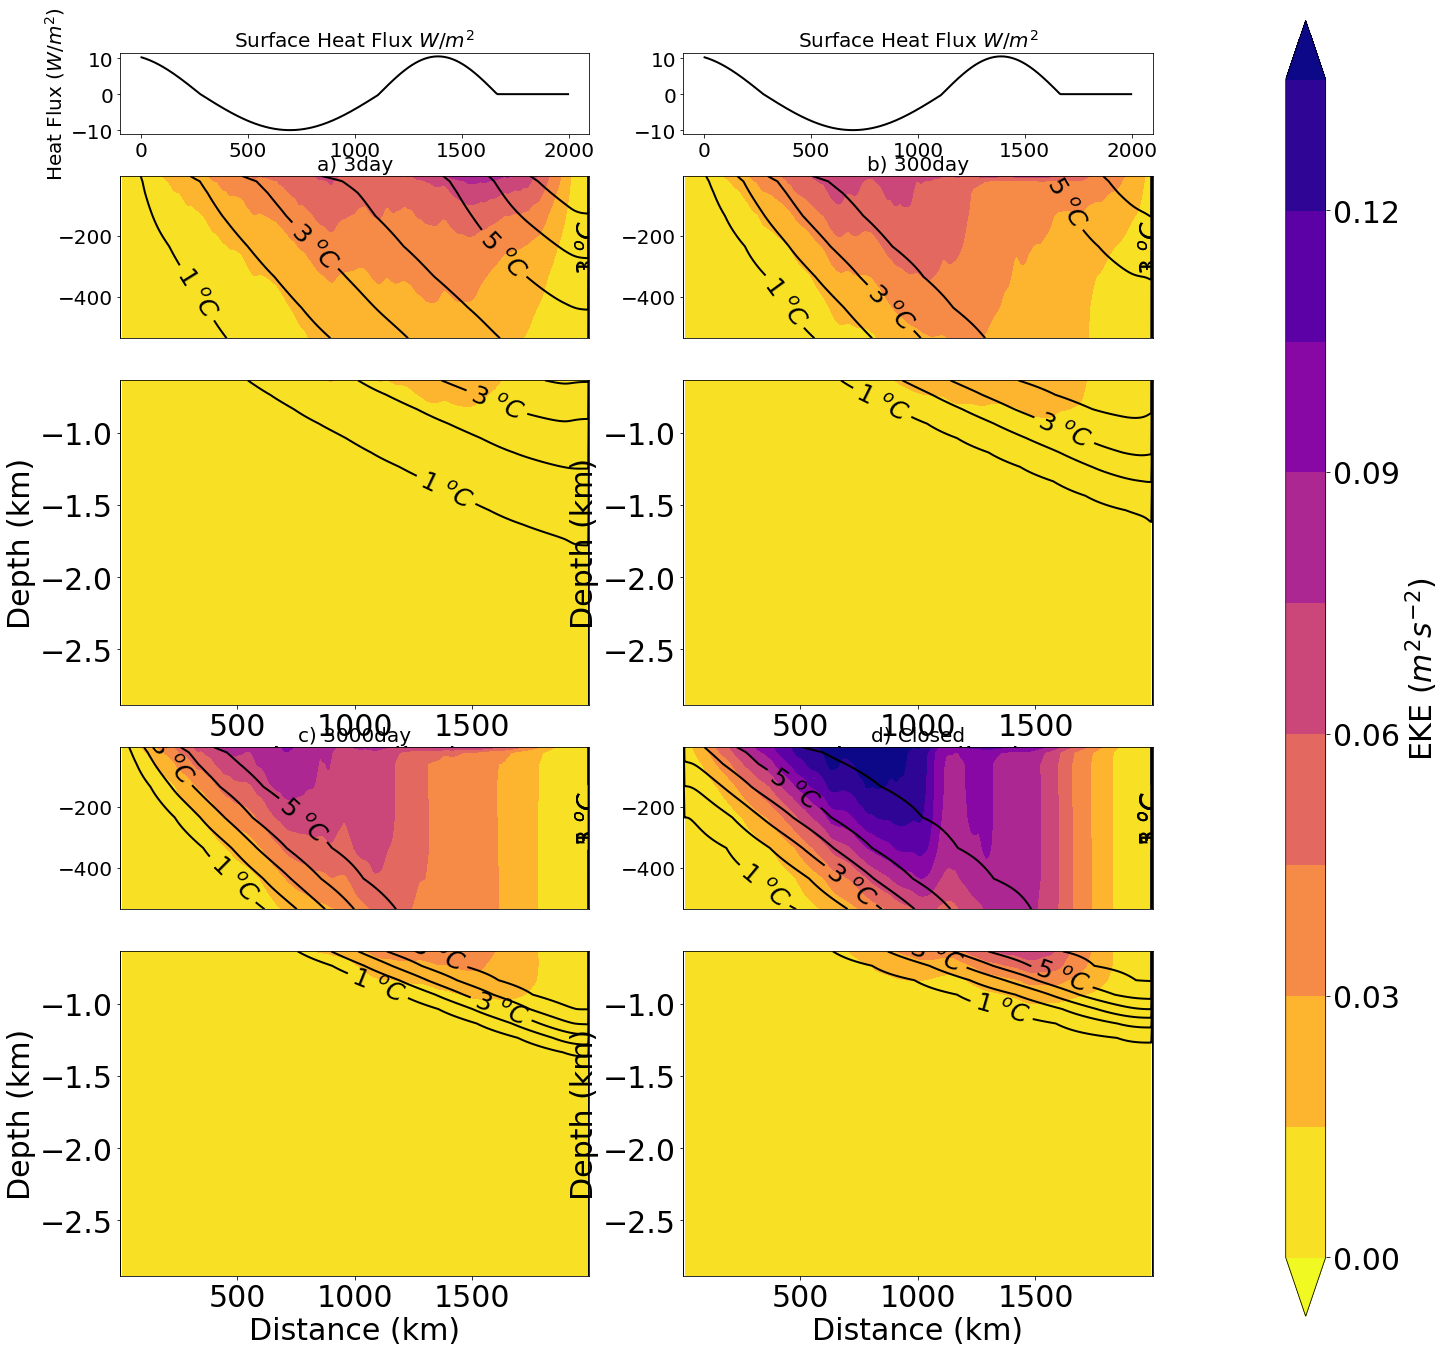

In [30]:
fig = plt.figure(figsize=(18.5, 22.5))
# Create Panels
Psi_levs = np.arange(-0., .15, .015)
Psi_ticks =np.arange(-0., .15, .03)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(4, 4, height_ratios=[1, 2, 4, 4])
ax = plt.subplot(gs[3])
ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
if Full == 'N':
    gs = gridspec.GridSpec(5, 2, height_ratios=[1, 2, 4, 2, 4])
    ax = plt.subplot(gs[0])
    ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    EKE = c.calc_EKE()
    if i <= 1:
        pos = 2
    else:
        pos = 4
    #gs.update(hspace=0.2)
    ax = plt.subplot(gs[pos+i])
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(c.yc/1000, c.zc[0:8],
                EKE[0:8,:], Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*c.dzf)/-c.zc[-1])
    q = ax.contour(c.yc/1000, c.zc[0:8], Tavlat[0:8,:], Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=20)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=20)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(bottom='off',labelbottom='off')
    #gs.update(hspace=0.05)
    ax2 = plt.subplot(gs[2+pos+i])
    p = ax2.contourf(c.yc/1000, c.zc[8::]/1000,
                EKE[8::,:], Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*c.dzf)/-c.zc[-1])
    q = ax2.contour(c.yc/1000, c.zc[8::]/1000, Tavlat[8::], Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)

  
    ax2.set_xlabel('Distance (km)', fontsize=30)
    ax2.set_ylabel('Depth (km)', fontsize=30)
    ax2.tick_params(axis='both', which='major', labelsize=30)
#plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('EKE $(m^2s^{-2})$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

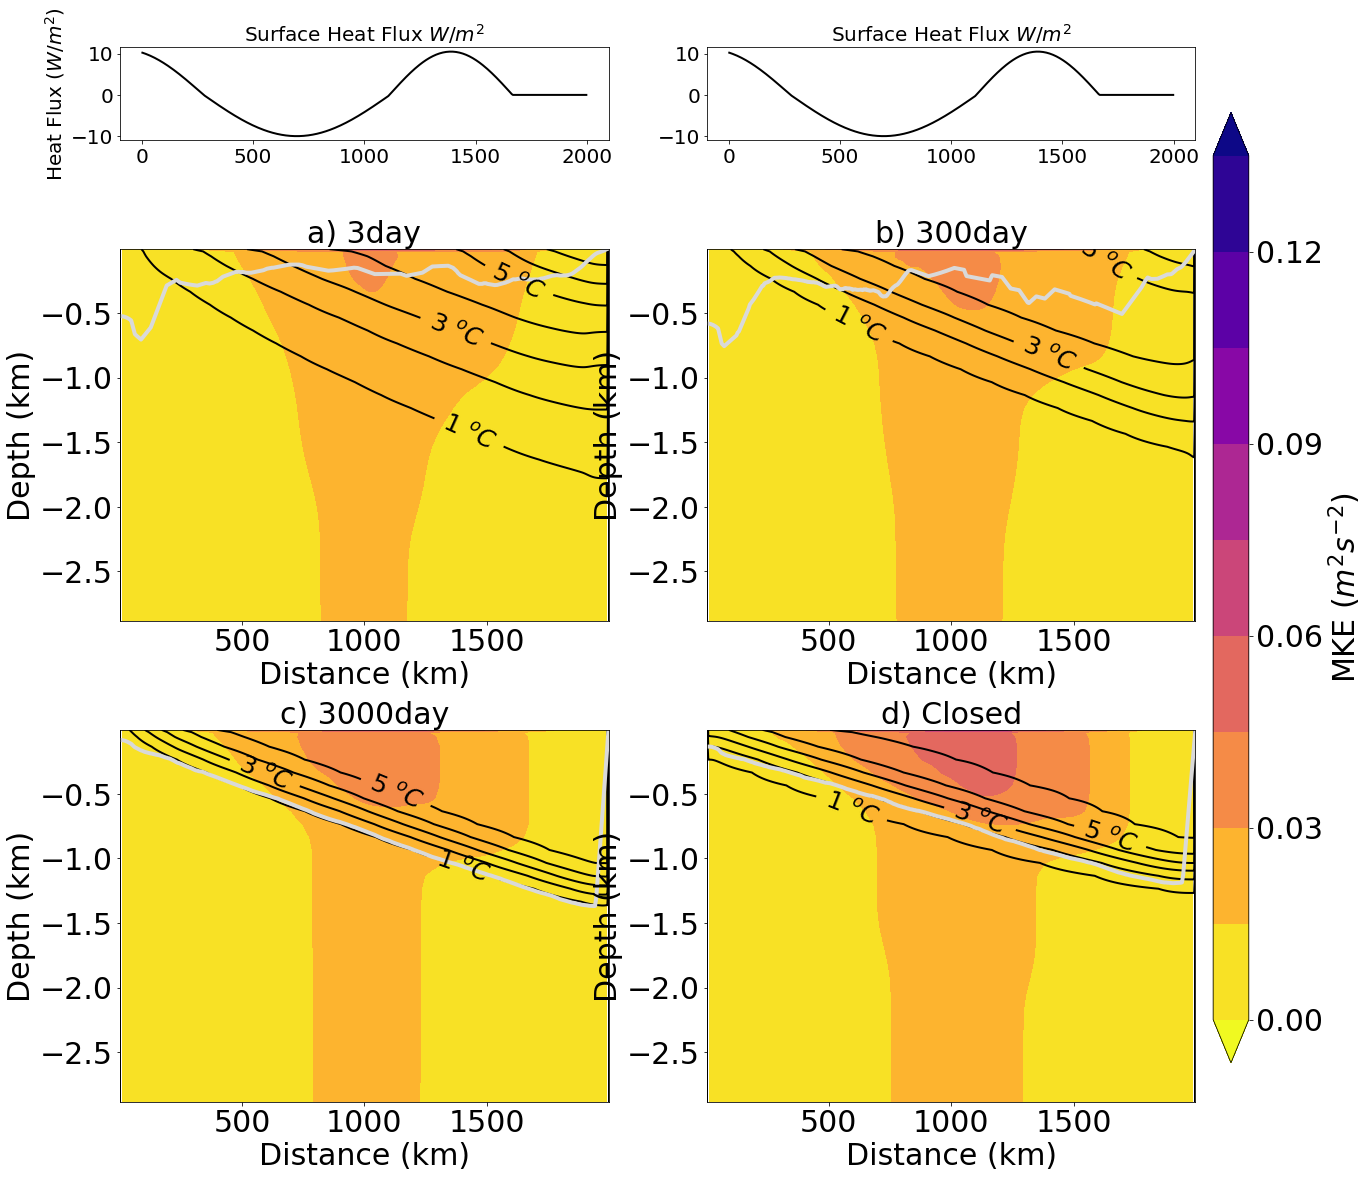

In [31]:
fig = plt.figure(figsize=(16.5, 16.5))
# Create Panels
Psi_levs = np.arange(-0., .15, .015)
Psi_ticks =np.arange(-0., .15, .03)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4, 4])
ax = plt.subplot(gs[3])
ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
if Full == 'N':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    EKE = c.calc_MKE()
    ax = plt.subplot(gs[2+i])
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(c.yc/1000, c.zc/1000,
                EKE,Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*c.dzf)/-c.zc[-1])
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    DDL = np.zeros(len(c.yc))
    psi = c.get_psi_iso()
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<0.9999999999)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[0]
        else:
            a = b[0]
            
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            DDL[jj] = (depths[a-1,jj]+depths[a,jj])/2
        else:
            DDL[jj] = depths[a,jj]
   
    r = ax.plot(c.yc/1000,SG.savitzky_golay(-DDL/1000,21,1),scalex=False,scaley=False, color='0.85', linewidth=4)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('MKE $(m^2s^{-2})$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

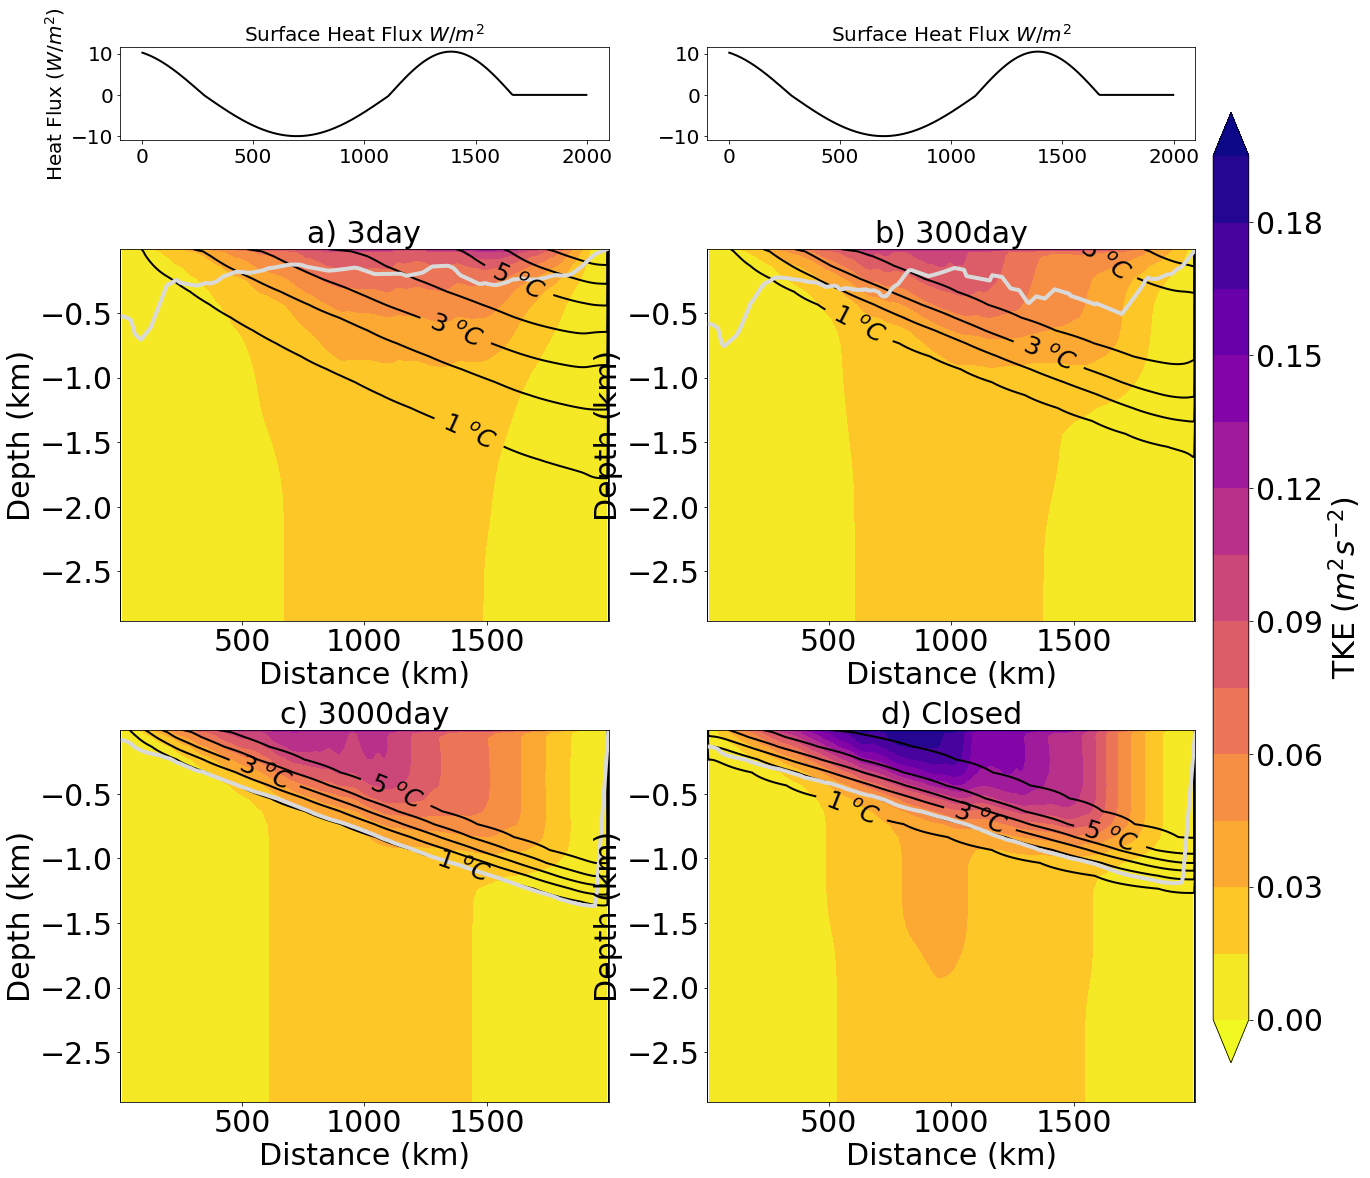

In [32]:
fig = plt.figure(figsize=(16.5, 16.5))
# Create Panels
Psi_levs = np.arange(-0., .2, .015)
Psi_ticks =np.arange(-0., .2, .03)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4, 4])
ax = plt.subplot(gs[3])
ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
if Full == 'N':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    TKE = c.calc_MKE()+c.calc_EKE()
    ax = plt.subplot(gs[2+i])
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(c.yc/1000, c.zc/1000,
                TKE,Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*c.dzf)/-c.zc[-1])
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    DDL = np.zeros(len(c.yc))
    psi = c.get_psi_iso()
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<0.9999999999)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[0]
        else:
            a = b[0]
            
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            DDL[jj] = (depths[a-1,jj]+depths[a,jj])/2
        else:
            DDL[jj] = depths[a,jj]
   
    r = ax.plot(c.yc/1000,SG.savitzky_golay(-DDL/1000,21,1),scalex=False,scaley=False, color='0.85', linewidth=4)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('TKE $(m^2s^{-2})$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

3
300
3000
Closed


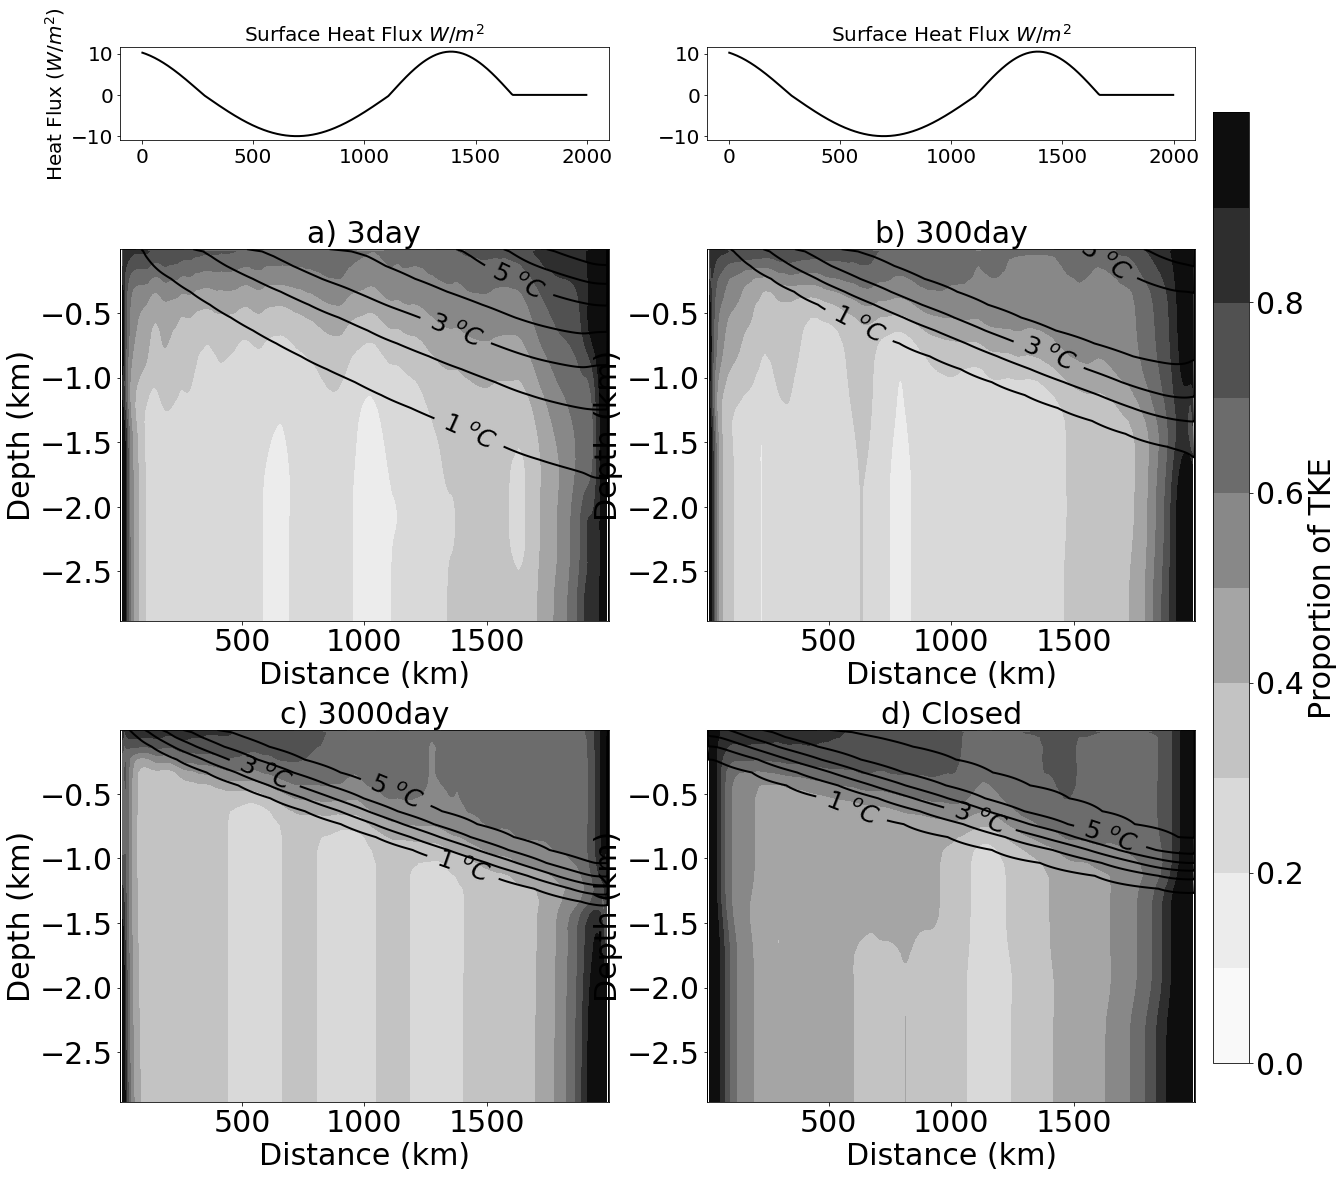

In [34]:
fig = plt.figure(figsize=(16.5, 16.5))
# Create Panels
TKEt = []
EKEt = []
APEt = []
Psi_levs = np.arange(-0.,1.1, .1)
Psi_ticks =np.arange(-0., 1., .2)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4, 4])

if Full == 'N':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
else:
    ax = plt.subplot(gs[0])
    ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[2])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    TKE = c.calc_EKE()/(c.calc_MKE()+c.calc_EKE())
    print str(tau[Runs[i]])
    CellVol = 5000*5000*1000*np.tile(c.dzf,(c.Nx,c.Ny,1)).T/c.Nx
    TKEt.append(np.sum((c.calc_MKE_all()+c.calc_EKE_all())*CellVol))#/np.sum(CellVol))
    EKEt.append(np.sum(c.calc_EKE_all()*CellVol))#/np.sum(CellVol))
    g = AC.APEcomputer(c)
    APE = g.calc_APE()
    APEt.append(np.sum(APE))#/np.sum(CellVol))
    ax = plt.subplot(gs[2+i])
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(c.yc/1000, c.zc/1000,
                TKE,Psi_levs, cmap=plt.cm.Greys)
    
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*c.dzf)/-c.zc[-1])
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    """PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    DDL = np.zeros(len(c.yc))
    psi = c.get_psi_iso()
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<0.9999999999)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[0]
        else:
            a = b[0]
            
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            DDL[jj] = (depths[a-1,jj]+depths[a,jj])/2
        else:
            DDL[jj] = depths[a,jj]"""
   
    #r = ax.plot(c.yc/1000,SG.savitzky_golay(-DDL/1000,21,1),scalex=False,scaley=False, color='0.85', linewidth=4)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('Proportion of TKE', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

In [ ]:
plt.plot([3,300,3000,10**5],np.array(TKEt)*10**-15,'-bx')
plt.plot([3,300,3000,10**5],np.array(EKEt)*10**-15,'-ko')
plt.plot([3,300,3000,10**5],np.array(APEt)*10**-15,'-g+')
plt.xscale("log")
#plt.ylim(-0.1,13)
plt.xlabel('Relaxation timescale (days)', fontsize=20)
plt.ylabel(r'PJ', fontsize=20)
plt.title("Domain integrated EKE (black),\n KE (blue) and APE (green)", fontsize=20)

In [ ]:
fig = plt.figure(figsize=(14.5, 12.5))
plt.plot([3,300,3000,10**5],(TKEt-TKEt[0])*10**-15,'-bx',linewidth=2)
plt.plot([3,300,3000,10**5],(EKEt-EKEt[0])*10**-15,'-ko',linewidth=2)
plt.plot([3,300,3000,10**5],(APEt-APEt[0])*10**-15,'-g+',linewidth=2)
plt.xscale("log")
#plt.ylim(-0.1,13)
plt.xlabel('Relaxation timescale (days)', fontsize=30)
plt.ylabel(r'PJ', fontsize=30)
plt.title("$\Delta$ in domain integrated EKE (black),\n KE (blue) and APE (green) \n", fontsize=30)
plt.xticks([10**0,10**2,10**3,10**5], fontsize=20)
plt.yticks(fontsize=20)

In [ ]:
plt.plot([3, 10, 30, 100, 300,3000, 10**5],np.array(TKEt)*10**-15,'-bx')
plt.xscale("log")
#plt.ylim(-0.1,13)
plt.title('Domain integrated KE', fontsize=20)
plt.xlabel('Relaxation timescale (days)', fontsize=20)
plt.ylabel(r'$KE (PJ)$', fontsize=20)

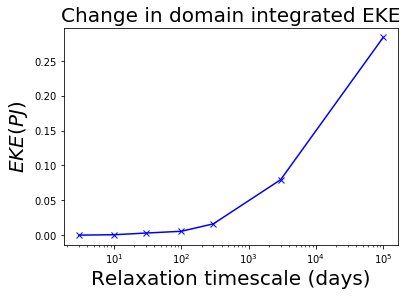

In [17]:
plt.plot([3, 10, 30, 100, 300,3000,  10**5],(np.array(EKEt)-np.array(EKEt)[0])*10**-15,'-bx')
plt.xscale("log")
#plt.ylim(-0.1,13)
plt.title('Change in domain integrated EKE', fontsize=20)
plt.xlabel('Relaxation timescale (days)', fontsize=20)
plt.ylabel(r'$EKE (PJ)$', fontsize=20)

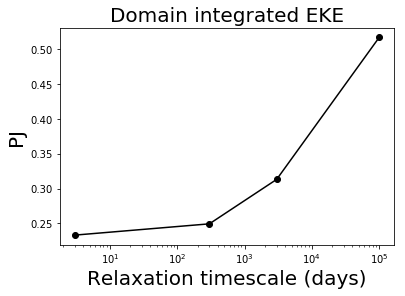

In [10]:
plt.plot([3,300,3000,10**5],np.array(EKEt)*10**-15,'-ko')
plt.xscale("log")
#plt.ylim(-0.1,13)
plt.xlabel('Relaxation timescale (days)', fontsize=20)
plt.ylabel(r'PJ', fontsize=20)
plt.title("Domain integrated EKE", fontsize=20)

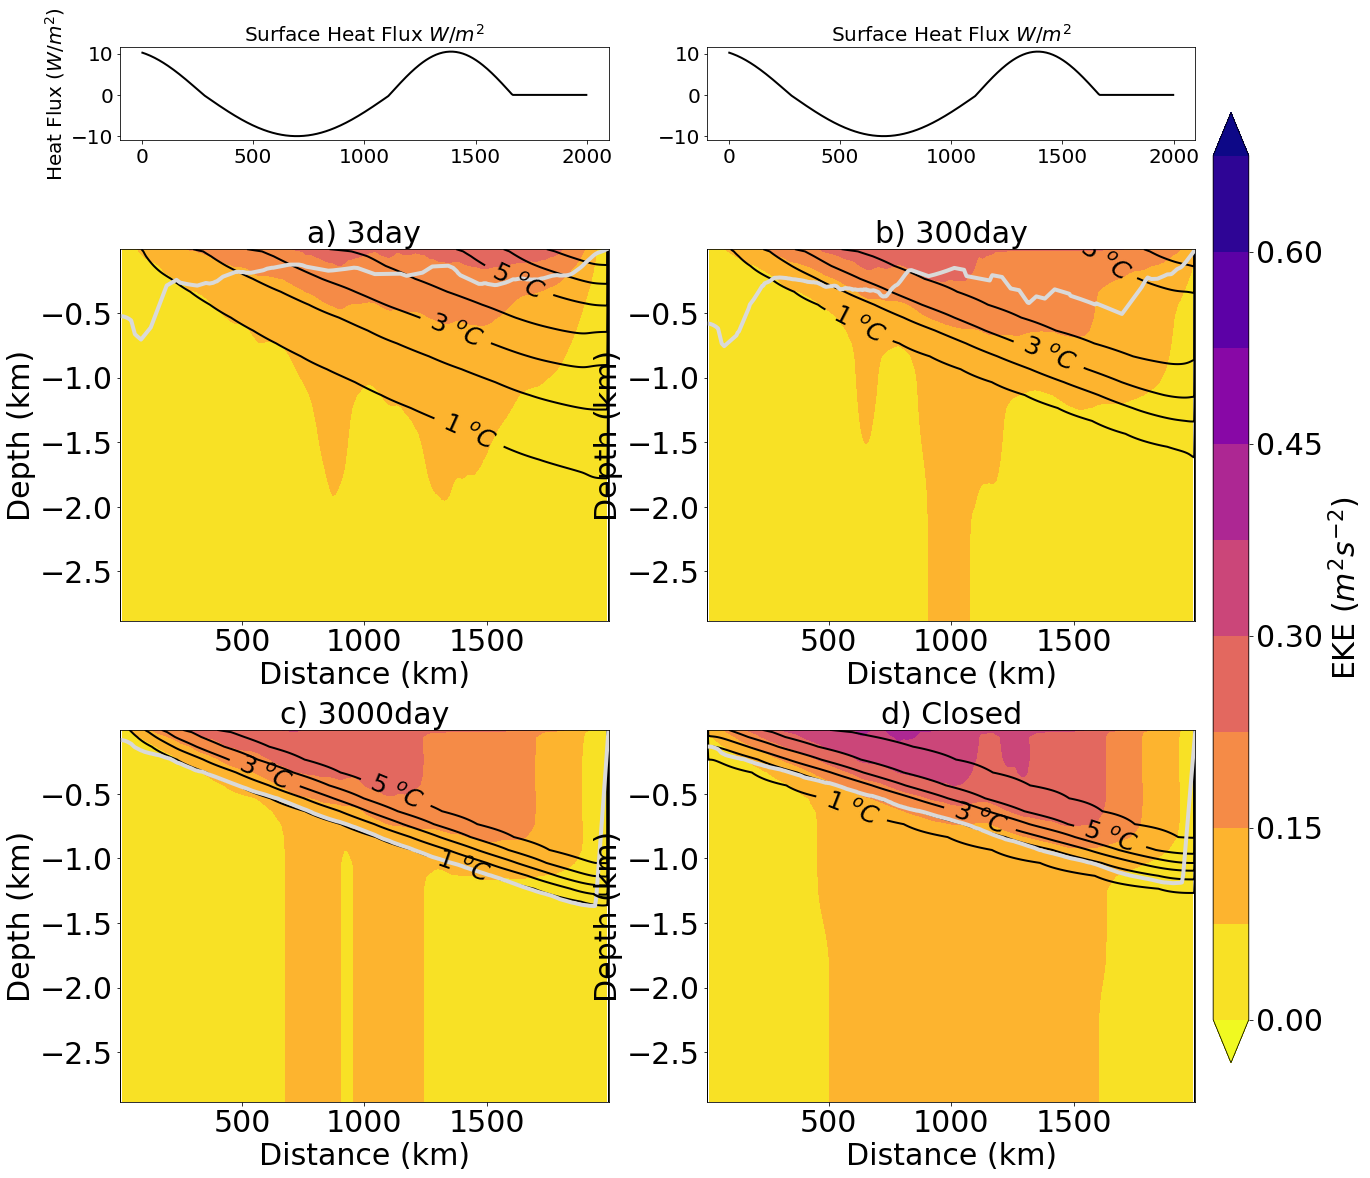

In [35]:
fig = plt.figure(figsize=(16.5, 16.5))
# Create Panels
Psi_levs = np.arange(-0., .15, .015)
Psi_ticks =np.arange(-0., .15, .03)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4, 4])
ax = plt.subplot(gs[3])
ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
if Full == 'N':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    
    EKE = c.calc_EKE()
    ax = plt.subplot(gs[2+i])
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(c.yc/1000, c.zc/1000,
                np.sqrt(EKE), Psi_levs*5, cmap=plt.cm.plasma_r, extend='both')
    
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*c.dzf)/-c.zc[-1])
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    DDL = np.zeros(len(c.yc))
    psi = c.get_psi_iso()
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<0.9999999999)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[0]
        else:
            a = b[0]
            
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            DDL[jj] = (depths[a-1,jj]+depths[a,jj])/2
        else:
            DDL[jj] = depths[a,jj]
   
    r = ax.plot(c.yc/1000,SG.savitzky_golay(-DDL/1000,21,1),scalex=False,scaley=False, color='0.85', linewidth=4)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks*5)
cbar.ax.set_ylabel('EKE $(m^2s^{-2})$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

In [40]:
# Some parameters
VAR = 'Psi'  # Pick what plot
Full = 'Y'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Year = 'PSI.nc'
Qplot = 'Y'

In [56]:

if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']

# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/VSQ.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

In [57]:
fig = plt.figure(figsize=(16.5, 16.5))
# Create Panels
TKEt = []
EKEt = []
APEt = []
Psi_levs = np.arange(-0.,1.1, .1)
Psi_ticks =np.arange(-0., 1., .2)
Eddy_ticks = (np.arange(-3, 1, .5))



for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    TKE = c.calc_EKE()/(c.calc_MKE()+c.calc_EKE())
    print str(tau[Runs[i]])
    CellVol = 5000*5000*1000*np.tile(c.dzf,(c.Nx,c.Ny,1)).T/c.Nx
    TKEt.append(np.sum((c.calc_MKE_all()+c.calc_EKE_all())*CellVol))#/np.sum(CellVol))
    EKEt.append(np.sum(c.calc_EKE_all()*CellVol))#/np.sum(CellVol))
    g = AC.APEcomputer(c)
    APE = g.calc_APE()
    APEt.append(np.sum(APE))#/np.sum(CellVol))
   


3
10
30
100
300
3000
10000
Closed


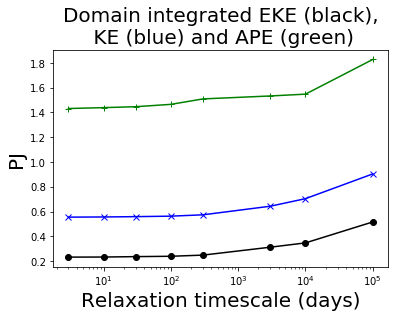

In [58]:
plt.plot([3,10,30,100,300,3000,10000,10**5],np.array(TKEt)*10**-15,'-bx')
plt.plot([3,10,30,100,300,3000,10000,10**5],np.array(EKEt)*10**-15,'-ko')
plt.plot([3,10,30,100,300,3000,10000,10**5],np.array(APEt)*10**-15,'-g+')
plt.xscale("log")
#plt.ylim(-0.1,13)
plt.xlabel('Relaxation timescale (days)', fontsize=20)
plt.ylabel(r'PJ', fontsize=20)
plt.title("Domain integrated EKE (black),\n KE (blue) and APE (green)", fontsize=20)

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45]), <a list of 11 Text yticklabel objects>)

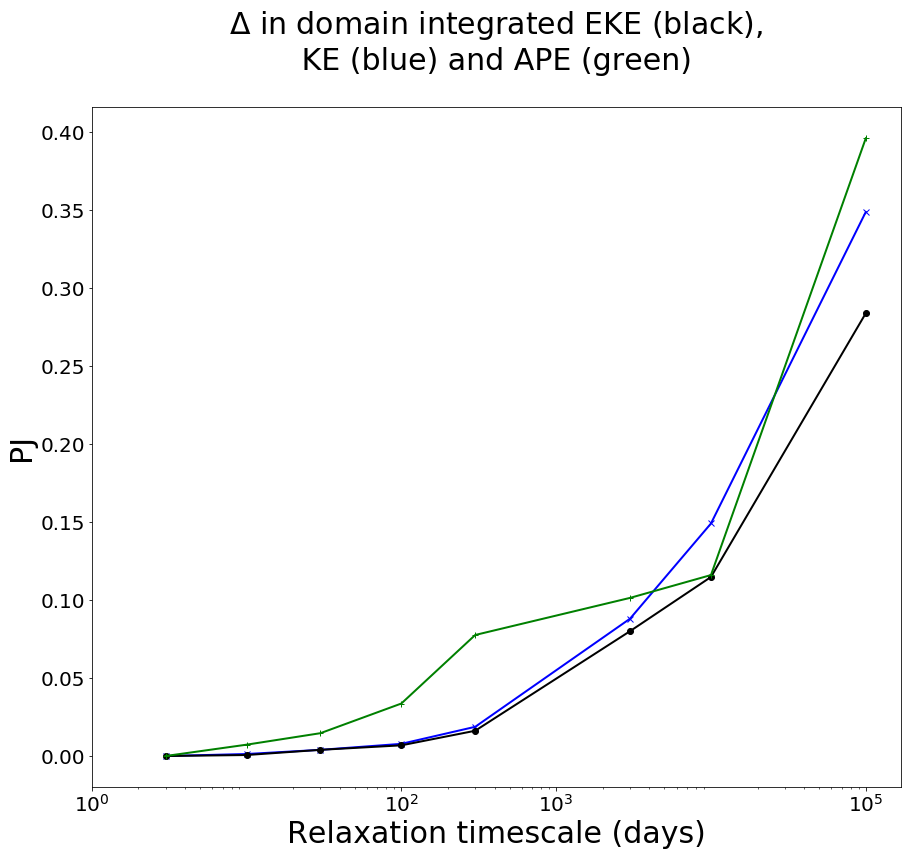

In [60]:
fig = plt.figure(figsize=(14.5, 12.5))
plt.plot([3,10,30,100,300,3000,10000,10**5],(TKEt-TKEt[0])*10**-15,'-bx',linewidth=2)
plt.plot([3,10,30,100,300,3000,10000,10**5],(EKEt-EKEt[0])*10**-15,'-ko',linewidth=2)
plt.plot([3,10,30,100,300,3000,10000,10**5],(APEt-APEt[0])*10**-15,'-g+',linewidth=2)
plt.xscale("log")
#plt.ylim(-0.1,13)
plt.xlabel('Relaxation timescale (days)', fontsize=30)
plt.ylabel(r'PJ', fontsize=30)
plt.title("$\Delta$ in domain integrated EKE (black),\n KE (blue) and APE (green) \n", fontsize=30)
plt.xticks([10**0,10**2,10**3,10**5], fontsize=20)
plt.yticks(fontsize=20)

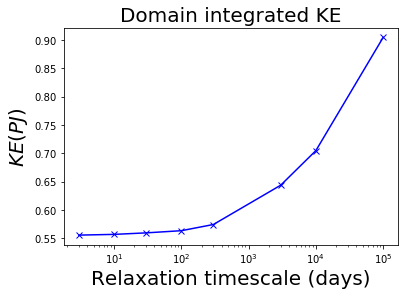

In [61]:
plt.plot([3, 10, 30, 100, 300,3000,10000, 10**5],np.array(TKEt)*10**-15,'-bx')
plt.xscale("log")
#plt.ylim(-0.1,13)
plt.title('Domain integrated KE', fontsize=20)
plt.xlabel('Relaxation timescale (days)', fontsize=20)
plt.ylabel(r'$KE (PJ)$', fontsize=20)

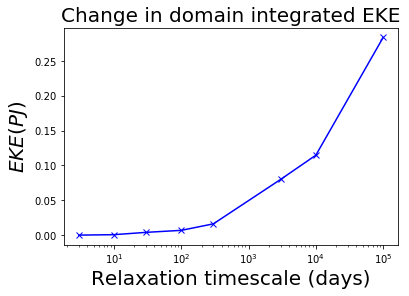

In [62]:
plt.plot([3, 10, 30, 100, 300,3000,10000,10**5],(np.array(EKEt)-np.array(EKEt)[0])*10**-15,'-bx')
plt.xscale("log")
#plt.ylim(-0.1,13)
plt.title('Change in domain integrated EKE', fontsize=20)
plt.xlabel('Relaxation timescale (days)', fontsize=20)
plt.ylabel(r'$EKE (PJ)$', fontsize=20)